## Code Architecture
![Architecture](img/dqn_init.drawio.png)

### Import Libraries

In [1]:
import numpy as np
# import keras.backend.tensorflow_backend as backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, ZeroPadding2D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm.notebook import tqdm_notebook
import os
from PIL import Image
import cv2


import matplotlib.pyplot as plt
from IPython import display
%matplotlib notebook
%matplotlib inline

2022-09-14 16:10:47.875006: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Invalid MIT-MAGIC-COOKIE-1 key

### Set hyper parameters

In [2]:
LOAD_MODEL = None # Path of the model or none

DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 10 # 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MAX_TRY_IN_EPISODE = 15 # 200
MIN_REWARD = 0 # -MAX_TRY_IN_EPISODE # 0 For model save
# MEMORY_FRACTION = 0.20 # For GPU

BORDER_PENALTY = 2

# Environment settings
EPISODES = 5000 # 20_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.9 # 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes

SHOW_PREVIEW = True

### Object's class

In [3]:
class Blob:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, size)
        self.y = np.random.randint(0, size)

    def __str__(self):
        return f"Blob ({self.x}, {self.y})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=0)
        elif choice == 1:
            self.move(x=-1, y=0)
        elif choice == 2:
            self.move(x=0, y=1)
        elif choice == 3:
            self.move(x=0, y=-1)
        elif choice == 4:
            self.move(x=1, y=1)
        elif choice == 5:
            self.move(x=-1, y=-1)
        elif choice == 6:
            self.move(x=-1, y=1)
        elif choice == 7:
            self.move(x=1, y=-1)
        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1


## Game Environment

In [4]:
class BlobEnv:
    SIZE = 4 # 10
    RETURN_IMAGES = True
    MOVE_PENALTY = 1
    ENEMY_PENALTY = 300
    FOOD_REWARD = 25
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 4
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    # the dict! (colors)
    d = {1: (255, 175, 0),
         2: (0, 255, 0),
         3: (0, 0, 255)}

    def reset(self):
        self.player = Blob(self.SIZE)
        self.food = Blob(self.SIZE)
        while self.food == self.player:
            self.food = Blob(self.SIZE)
        self.enemy = Blob(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Blob(self.SIZE)

        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = (self.player-self.food) + (self.player-self.enemy)
        return observation

    def step(self, action):
        self.episode_step += 1
        self.player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if self.RETURN_IMAGES:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player-self.food) + (self.player-self.enemy)

        if self.player == self.enemy:
            reward = -self.ENEMY_PENALTY
        elif self.player == self.food:
            reward = self.FOOD_REWARD
        else:
            reward = -self.MOVE_PENALTY

        done = False
        if reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or self.episode_step >= MAX_TRY_IN_EPISODE:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(1)

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img

### ?

In [5]:
# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
#backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')


## Modify Tensorboard

In [6]:
# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.create_file_writer(self.log_dir)
        self._log_write_dir = self.log_dir

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        self.model = model

        self._train_dir = os.path.join(self._log_write_dir, 'train')
        self._train_step = self.model._train_counter

        self._val_dir = os.path.join(self._log_write_dir, 'validation')
        self._val_step = self.model._test_counter

        self._should_write_train_graph = False

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)
    
    def _write_logs(self, logs, index):
        with self.writer.as_default():
            for name, value in logs.items():
                tf.summary.scalar(name, value, step=index)
                self.step += 1
                self.writer.flush()


## Agent

In [7]:
# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0
        
        # Print model summary
        self.model.summary()
        self.target_model.summary()

    def create_model(self):
        
        if LOAD_MODEL is not None:
            print(f"Loading Model: {LOAD_MODEL}")
            model = load_model(LOAD_MODEL)
            print("Model Loaded!")
        
        else:
            model = Sequential()
            
            model.add(Conv2D(3, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES, padding="same"))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
            # model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
            model.add(Activation('relu'))
            # model.add(MaxPooling2D(pool_size=(2, 2)))

            # model.add(Conv2D(256, (3, 3)))
            model.add(Conv2D(3, (3, 3), padding="same"))
            model.add(Activation('relu'))
            # model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
            model.add(Dense(64))

            model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
            model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q # Basically learning_rate = 1
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255, verbose=0)[0]


## Main Loop (Model Train)

In [8]:
env = BlobEnv()
agent = DQNAgent()

mean_rewards = []

# Iterate over episodes
for episode in tqdm_notebook(range(1, EPISODES + 1), desc = 'Progress: ', ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        #if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        env.render()
        # print("Reward: ",reward)

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    
    mean = np.mean(ep_rewards)
    mean_rewards.append(mean)
    # print(mean)
    # ax.plot(mean)
    # plt.autoscale()
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
        
        


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 3)           84        
                                                                 
 activation (Activation)     (None, 4, 4, 3)           0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 3)           84        
                                                                 
 activation_1 (Activation)   (None, 4, 4, 3)           0         
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 64)                3136      
                                                                 
 dense_1 (Dense)             (None, 4)                 2

2022-09-14 16:10:50.022054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Progress:   0%|          | 0/5000 [00:00<?, ?episodes/s]

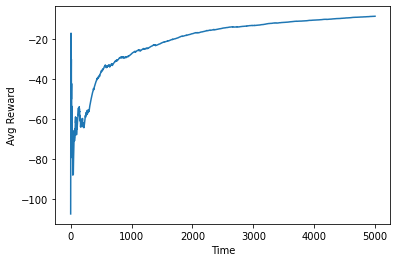

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time')
ax.set_ylabel('Avg Reward')
ax.plot(mean_rewards)
plt.show()

In [10]:
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# import time
# from IPython import display

# %matplotlib inline

# y_arr = [0,1,2,5,9,4]

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(y_arr)
# # plt.show()

# for i in range (100000):
#     # print(i)
#     y_arr.append(i)
#     ax.plot(y_arr)
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     # plt.gcf().canvas.draw()
#     # fig.canvas.draw()
#     #fig.canvas.flush_events()
#     # time.sleep(0.1)
#     # 

In [11]:
# import matplotlib.pyplot as plt
# import numpy as np
# import math
# import time
# from IPython import display

# %matplotlib inline

# y_arr = [0,1,2,5,9,4]

# fig = plt.figure()
# ax = fig.add_subplot(111)

# for i in range (10):
#     # print(i)
#     y_arr.append(i)
#     time.sleep(0.1)
#     # 
# ax.plot(y_arr)
# plt.show()